In [1]:
import itertools
import matlab.engine
import plotly.express as px

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import time
import pandas as pd
import glob
from copy import deepcopy
import os
import sys
from joblib import Parallel, delayed, cpu_count, dump

project_path = r'D:\OneDrive - Nexus365\Project\pirate_fmri\Analysis'
sys.path.append(os.path.join(project_path,'scripts'))
from multivariate.dataloader import ActivityPatternDataLoader
from multivariate.helper import compute_rdm, checkdir, scale_feature,lower_tri,upper_tri
from multivariate.modelrdms import ModelRDM
from multivariate.rsa_searchlight import RSASearchLight
from multivariate.rsa_estimator import PatternCorrelation,MultipleRDMRegression,NeuralDirectionCosineSimilarity
from multivariate.rsa_runner import RSARunner

from sklearn.manifold import MDS,TSNE
import sklearn.manifold as manifold
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import scipy
import sklearn

In [2]:
#https://stackoverflow.com/questions/27426668/row-titles-for-matplotlib-subplot
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

In [3]:
with open(os.path.join(project_path,'scripts','pirate_defaults.json')) as f:
    pirate_defaults = json.load(f)
    subid_list = pirate_defaults['participants']['validids']
    fmribeh_dir = pirate_defaults['directory']['fmribehavior']
    fmridata_dir = pirate_defaults['directory']['fmri_data']
    nonlearners = pirate_defaults['participants']['nonlearnerids']
    nongeneralizers = pirate_defaults['participants']['nongeneralizerids']
    
ROIRSA_output_path = os.path.join(fmridata_dir,'ROIRSA','DPhilSeminarPosterPlot')
checkdir(ROIRSA_output_path)

preprocess = ["unsmoothedLSA","smoothed5mmLSA"]
n_sess = {
          "localizer":1,
          "noconcatall":1,
          "oddeven":2,
          "fourruns":4,
          }    


In [331]:
maskdir = r'D:\OneDrive - Nexus365\Project\pirate_fmri\Analysis\data\fmri\masks\func\DPhilSeminarPosterPlot'
laterality = ["bilateral"]
roi_dict = dict(zip(
    ['Unsigned Distance \n Cuneus(L)','Unsigned Distance \n Superior Parietal Lobule(L)',
     'Unsigned Distance \n Middle Frontal Gyrus(R)','Unsigned Distance \n Superior and Middle Frontal Gyrus(L)', 
     'Cartesian \n Visual(Bilateral)',
     'notusedsphericalvisual'
     ],
    ['xydist_LeftCuneus','xydist_LeftParietalSup',
     'xydist_RightFrontalMidSup','xydist_LeftFrontalSup',
     'gtloc_bilateralVisual',
     'notusedsphericalvisual'
     ]
     ))

## RSA

In [5]:
n_job=10
for p in preprocess[:1]:
    beta_dir = {
        #"localizer":[os.path.join(fmridata_dir,p,'LSA_stimuli_localizer')],
        "oddeven":[os.path.join(fmridata_dir,p,'LSA_stimuli_navigation')]*2,

        }
    beta_fname = {
        "localizer":['stimuli_1r.nii'],
        "oddeven":['stimuli_odd.nii',
                   'stimuli_even.nii'],
        
        }
    vs_dir = {
              "no_selection":[],
              }
    for ds_name,ds in beta_dir.items():
        for vselect,vdir in vs_dir.items():
            mds_df_list = []
            rdm_df_list = []
            PS_df_list = []

            vsmask_dir = ds + vdir
            if vselect == "no_selection":
                vsmask_fname = ['mask.nii']*len(ds)
            elif vselect == "perm_rmask":
                vsmask_fname = ['mask.nii']*len(ds) + ['permuted_reliability_mask.nii']
            elif vselect == "reliability_ths0":
                vsmask_fname = ['mask.nii']*len(ds) + ['reliability_mask.nii']
            taskname = "navigation" if ds_name != "localizer" else ds_name

            for (roi,roi_fn), lat in itertools.product(roi_dict.items(), laterality):
                print(f"{p} - {ds_name} - {vselect} - {roi} = {lat}")
                funcmasks = [os.path.join(maskdir,f'{roi_fn}.nii')]
                RSA = RSARunner(participants=subid_list,
                                fmribeh_dir=fmribeh_dir,
                                beta_dir=ds, beta_fname=beta_fname[ds_name],
                                vsmask_dir=vsmask_dir, vsmask_fname=vsmask_fname,
                                pmask_dir=ds, pmask_fname=beta_fname[ds_name],
                                anatmasks=funcmasks,
                                nsession=n_sess[ds_name],
                                taskname=taskname)

unsmoothedLSA - oddeven - no_selection - Unsigned Distance 
 Cuneus(L) = bilateral
unsmoothedLSA - oddeven - no_selection - Unsigned Distance 
 Superior Parietal Lobule(L) = bilateral
unsmoothedLSA - oddeven - no_selection - Unsigned Distance 
 Middle Frontal Gyrus(R) = bilateral
unsmoothedLSA - oddeven - no_selection - Unsigned Distance 
 Superior and Middle Frontal Gyrus(L) = bilateral
unsmoothedLSA - oddeven - no_selection - Cartesian 
 Visual(Bilateral) = bilateral


In [6]:
RSA.get_modelRDM(subid="sub001").models.keys()

dict_keys(['gtlocEuclidean', 'gtlocCityBlock', 'gtloc1dx', 'gtloc1dy', 'feature2d', 'feature1dx', 'feature1dy', 'stimuli', 'stimuligroup', 'global_xsign', 'global_ysign', 'global_xysign', 'locwrtcentre_localglobal', 'locwrtcentre_localx', 'locwrtcentre_localy', 'locwrtcentre_localxy', 'locwrtlrbu_localglobal', 'locwrtlrbu_localx', 'locwrtlrbu_localy', 'locwrtlrbu_localxy', 'respglobal_xsign', 'respglobal_ysign', 'respglobal_xysign', 'resplocwrtcentre_localglobal', 'resplocwrtcentre_localx', 'resplocwrtcentre_localy', 'resplocwrtcentre_localxy', 'shuffledloc2d', 'resplocEuclidean', 'resplocCityBlock', 'resploc1dx', 'resploc1dy', 'within_gtlocEuclidean', 'between_gtlocEuclidean', 'within_gtlocCityBlock', 'between_gtlocCityBlock', 'within_gtloc1dx', 'between_gtloc1dx', 'within_gtloc1dy', 'between_gtloc1dy', 'within_feature2d', 'between_feature2d', 'within_feature1dx', 'between_feature1dx', 'within_feature1dy', 'between_feature1dy', 'within_stimuli', 'between_stimuli', 'within_stimuligroup

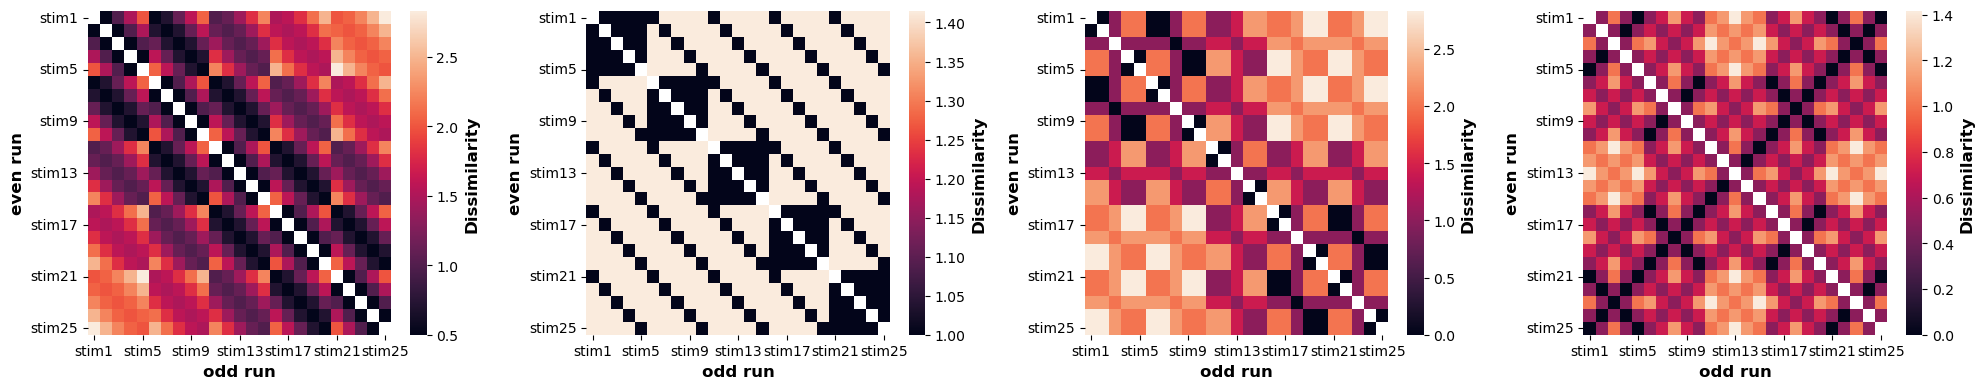

In [7]:
fig,axes=plt.subplots(1,4,figsize=(20,4))
for mname,ax in zip(["between_gtlocEuclidean","between_feature2d","between_global_xysign","between_locwrtcentre_localxy"],axes):
    rdm_mat = RSA.get_modelRDM(subid="sub001").models[mname]
    plot_mat = np.full_like(rdm_mat,fill_value=np.nan)
    plot_mat[lower_tri(rdm_mat)[1]] = lower_tri(rdm_mat)[0]

    sns.heatmap(plot_mat[25:,:25],ax = ax)
    ax.figure.axes[-1].set_ylabel('Dissimilarity',fontweight="bold",fontsize="large")
    ax.set_xlabel("stimuli")
    tick_val = np.arange(7)*4
    tick_lab = [f"stim{x + 1}" for x in tick_val]
    ax.set_xticks(np.array(tick_val)+0.5,labels=tick_lab)
    ax.set_yticks(np.array(tick_val)+0.5,labels=tick_lab)
    ax.set_xlabel("odd run",fontweight="bold",fontsize="large")
    ax.set_ylabel("even run",fontweight="bold",fontsize="large")
    ax.grid(False)
    ax.tick_params(axis="both",rotation=0,labelbottom=True, labelleft=True,labeltop=False, labelright=False,top=False)
    sns.despine(left=True, bottom=True, right=True)
fig.tight_layout()

In [8]:
n_job=10
for p in preprocess[:1]:
    beta_dir = {
        #"localizer":[os.path.join(fmridata_dir,p,'LSA_stimuli_localizer')],
        "oddeven":[os.path.join(fmridata_dir,p,'LSA_stimuli_navigation')]*2,

        }
    beta_fname = {
        "localizer":['stimuli_1r.nii'],
        "oddeven":['stimuli_odd.nii',
                   'stimuli_even.nii'],
        
        }
    vs_dir = {
              "no_selection":[],
              "reliability_ths0":[os.path.join(fmridata_dir,p,'reliability_noconcat')],
              "perm_rmask":[os.path.join(fmridata_dir,p,'reliability_noconcat')],
              }
    for ds_name,ds in beta_dir.items():
        for vselect,vdir in vs_dir.items():
            mds_df_list = []
            rdm_df_list = []
            PS_df_list = []

            vsmask_dir = ds + vdir
            if vselect == "no_selection":
                vsmask_fname = ['mask.nii']*len(ds)
            elif vselect == "perm_rmask":
                vsmask_fname = ['mask.nii']*len(ds) + ['permuted_reliability_mask.nii']
            elif vselect == "reliability_ths0":
                vsmask_fname = ['mask.nii']*len(ds) + ['reliability_mask.nii']
            taskname = "navigation" if ds_name != "localizer" else ds_name

            for (roi,roi_fn), lat in itertools.product(roi_dict.items(), laterality):
                print(f"{p} - {ds_name} - {vselect} - {roi} = {lat}")
                funcmasks = [os.path.join(maskdir,f'{roi_fn}.nii')]
                RSA = RSARunner(participants=subid_list,
                                fmribeh_dir=fmribeh_dir,
                                beta_dir=ds, beta_fname=beta_fname[ds_name],
                                vsmask_dir=vsmask_dir, vsmask_fname=vsmask_fname,
                                pmask_dir=ds, pmask_fname=beta_fname[ds_name],
                                anatmasks=funcmasks,
                                nsession=n_sess[ds_name],
                                taskname=taskname)
                
                corr_rdm_names = [
                    "gtlocEuclidean",
                    "locwrtcentre_localxy",
                 ]
                roirsa_config = {'corr_rdm_names':corr_rdm_names}
                _,rdm_df = RSA.run_ROIRSA(n_job,roirsa_config)
                rdm_df = rdm_df.assign(roi = roi, laterality = lat, voxselect = vselect, preprocess=p,ds = ds_name)
                rdm_df_list.append(rdm_df)
                
                if n_sess[ds_name]<2:
                    PS_df = RSA.run_ROIPS(outputdir=os.path.join(ROIRSA_output_path,'individual_cossim'),njobs=n_job)
                    PS_df = PS_df.assign(roi = roi, laterality = lat, voxselect = vselect, preprocess=p,ds = ds_name)
                    PS_df_list.append(PS_df)
            
            pd.concat(rdm_df_list,axis=0).to_csv(os.path.join(ROIRSA_output_path,f'roirdm_nocentering_{p}_{ds_name}_{vselect}.csv'))
            if n_sess[ds_name]<2:
                pd.concat(PS_df_list,axis=0).to_csv(os.path.join(ROIRSA_output_path,f'roiPS_nocentering_{p}_{ds_name}_{vselect}.csv'))

unsmoothedLSA - oddeven - no_selection - Unsigned Distance 
 Cuneus(L) = bilateral
unsmoothedLSA - oddeven - no_selection - Unsigned Distance 
 Superior Parietal Lobule(L) = bilateral
unsmoothedLSA - oddeven - no_selection - Unsigned Distance 
 Middle Frontal Gyrus(R) = bilateral
unsmoothedLSA - oddeven - no_selection - Unsigned Distance 
 Superior and Middle Frontal Gyrus(L) = bilateral
unsmoothedLSA - oddeven - no_selection - Cartesian 
 Visual(Bilateral) = bilateral
unsmoothedLSA - oddeven - reliability_ths0 - Unsigned Distance 
 Cuneus(L) = bilateral
unsmoothedLSA - oddeven - reliability_ths0 - Unsigned Distance 
 Superior Parietal Lobule(L) = bilateral
unsmoothedLSA - oddeven - reliability_ths0 - Unsigned Distance 
 Middle Frontal Gyrus(R) = bilateral
unsmoothedLSA - oddeven - reliability_ths0 - Unsigned Distance 
 Superior and Middle Frontal Gyrus(L) = bilateral
unsmoothedLSA - oddeven - reliability_ths0 - Cartesian 
 Visual(Bilateral) = bilateral
unsmoothedLSA - oddeven - perm_r

In [9]:
corr_rdm_names = [
                    "gtlocEuclidean",
                    "locwrtcentre_localxy",
                 ]
modelrdm_cols_oldname = corr_rdm_names
modelrdm_cols_newname = modelrdm_cols_oldname
modelrdm_cols = dict(zip(modelrdm_cols_oldname,modelrdm_cols_newname))

for p in preprocess[:1]:
    beta_dir = {
#        "localizer":[os.path.join(fmridata_dir,p,'LSA_stimuli_localizer')],
        "oddeven":[os.path.join(fmridata_dir,p,'LSA_stimuli_navigation')]*2,

        }
    beta_fname = {
        "localizer":['stimuli_1r.nii'],
        "oddeven":['stimuli_odd.nii',
                   'stimuli_even.nii'],
        
        }
    vs_dir = {
              "no_selection":[],
              }
    for ds_name,ds in beta_dir.items():
        for vselect,vdir in vs_dir.items():
            df = pd.read_csv(os.path.join(ROIRSA_output_path,f'roirdm_nocentering_{p}_{ds_name}_{vselect}.csv'))
            sub_type_dict = {'l':{1:'nonLearner',0:'Learner'},
                            'g':{1:'nonGeneralizer',0:'Generalizer'}}
            df['type'] = df['subid'].apply(
                lambda x: f"{sub_type_dict['g'][int(x in nongeneralizers)]}" #{sub_type_dict['l'][int(x in nonlearners)]} - 
            )
            df['run_comb'] = 1*(df['runA'] == df['runB'])
            df['run_comb'] = df['run_comb'].map({0:"between run",1:"within run"})
            df['group_comb'] = 1*(df['groupA'] == df['groupB'])
            df['group_comb'] = df['group_comb'].map({0:"between group",1:"within group"})
            df = df[df['run_comb']=="between run"]
            

unsmoothedLSA - oddeven - no_selection - gtlocEuclidean


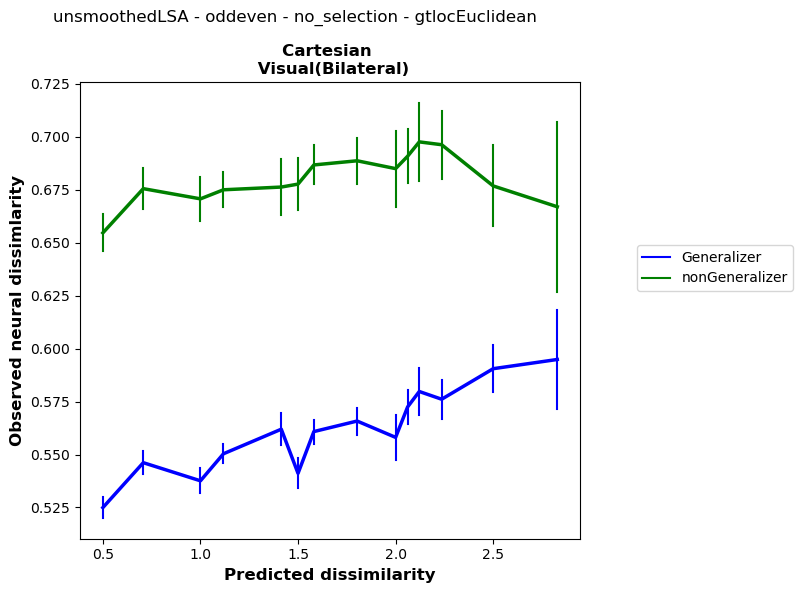

In [13]:
mn = "gtlocEuclidean"
m = modelrdm_cols[mn]
fig_suptitle = f'{p} - {ds_name} - {vselect} - {mn}'
print(fig_suptitle)
roi_dict = dict(zip(
    ['Cartesian \n Visual(Bilateral)'
     ],
    ['gtloc_bilateralVisual'
     ]
     ))
prows, pcols = np.unique(df['run_comb']).size, len(roi_dict)
fig,axes = plt.subplots(nrows=prows,ncols=pcols,figsize=(6,6))#(20,15)
for _,(g_name,g_df) in list(enumerate(df.groupby(['laterality','run_comb','roi']))):
    if (g_name[2] in roi_dict.keys()):    
        subdf = g_df.groupby([m,'type','subid'])['neural'].mean().reset_index()
        sns.lineplot(data=g_df,x=m,y='neural',ax=axes,
                    hue='type',palette=['blue','green'],#,'orange','red'],
                    err_style="bars",errorbar=("se", 1),
                    markers=True,alpha=1,linewidth=2.5)
        
        axes.set_title(g_name[2],fontweight="bold",fontsize="large")
        axes.set(adjustable="datalim")
        axes.set_xlabel("Predicted dissimilarity",fontweight="bold",fontsize="large")
        axes.set_ylabel("Observed neural dissimlarity",fontweight="bold",fontsize="large")

lines_labels = axes.get_legend_handles_labels()
[ax.get_legend().remove() for ax in fig.axes if ax.get_legend() is not None]
lines, labels = [sum(lol, []) for lol in zip(lines_labels)]
#select unique legends
lgd_idx = [np.where(np.array(labels)==x)[0][0] for x in np.unique(labels)]
lines, labels = np.array(lines)[lgd_idx],np.array(labels)[lgd_idx]
lgd = fig.legend(lines, labels,loc = 'lower center',bbox_to_anchor=(1.2,0.5), ncol=1)

grid = plt.GridSpec(prows, pcols)
#create_subtitle(fig, grid[0, ::], 'between run')
#create_subtitle(fig, grid[1, ::], 'within run')
fig.set_facecolor('w')

fig.suptitle(fig_suptitle)
fig.tight_layout()
checkdir(os.path.join(ROIRSA_output_path,'pair-wise dissimilarity plot'))
fig.savefig(os.path.join(ROIRSA_output_path,'pair-wise dissimilarity plot',f'{p}_{ds_name}_{vselect}_{m}.png'),
            bbox_inches='tight')

unsmoothedLSA - oddeven - no_selection - locwrtcentre_localxy


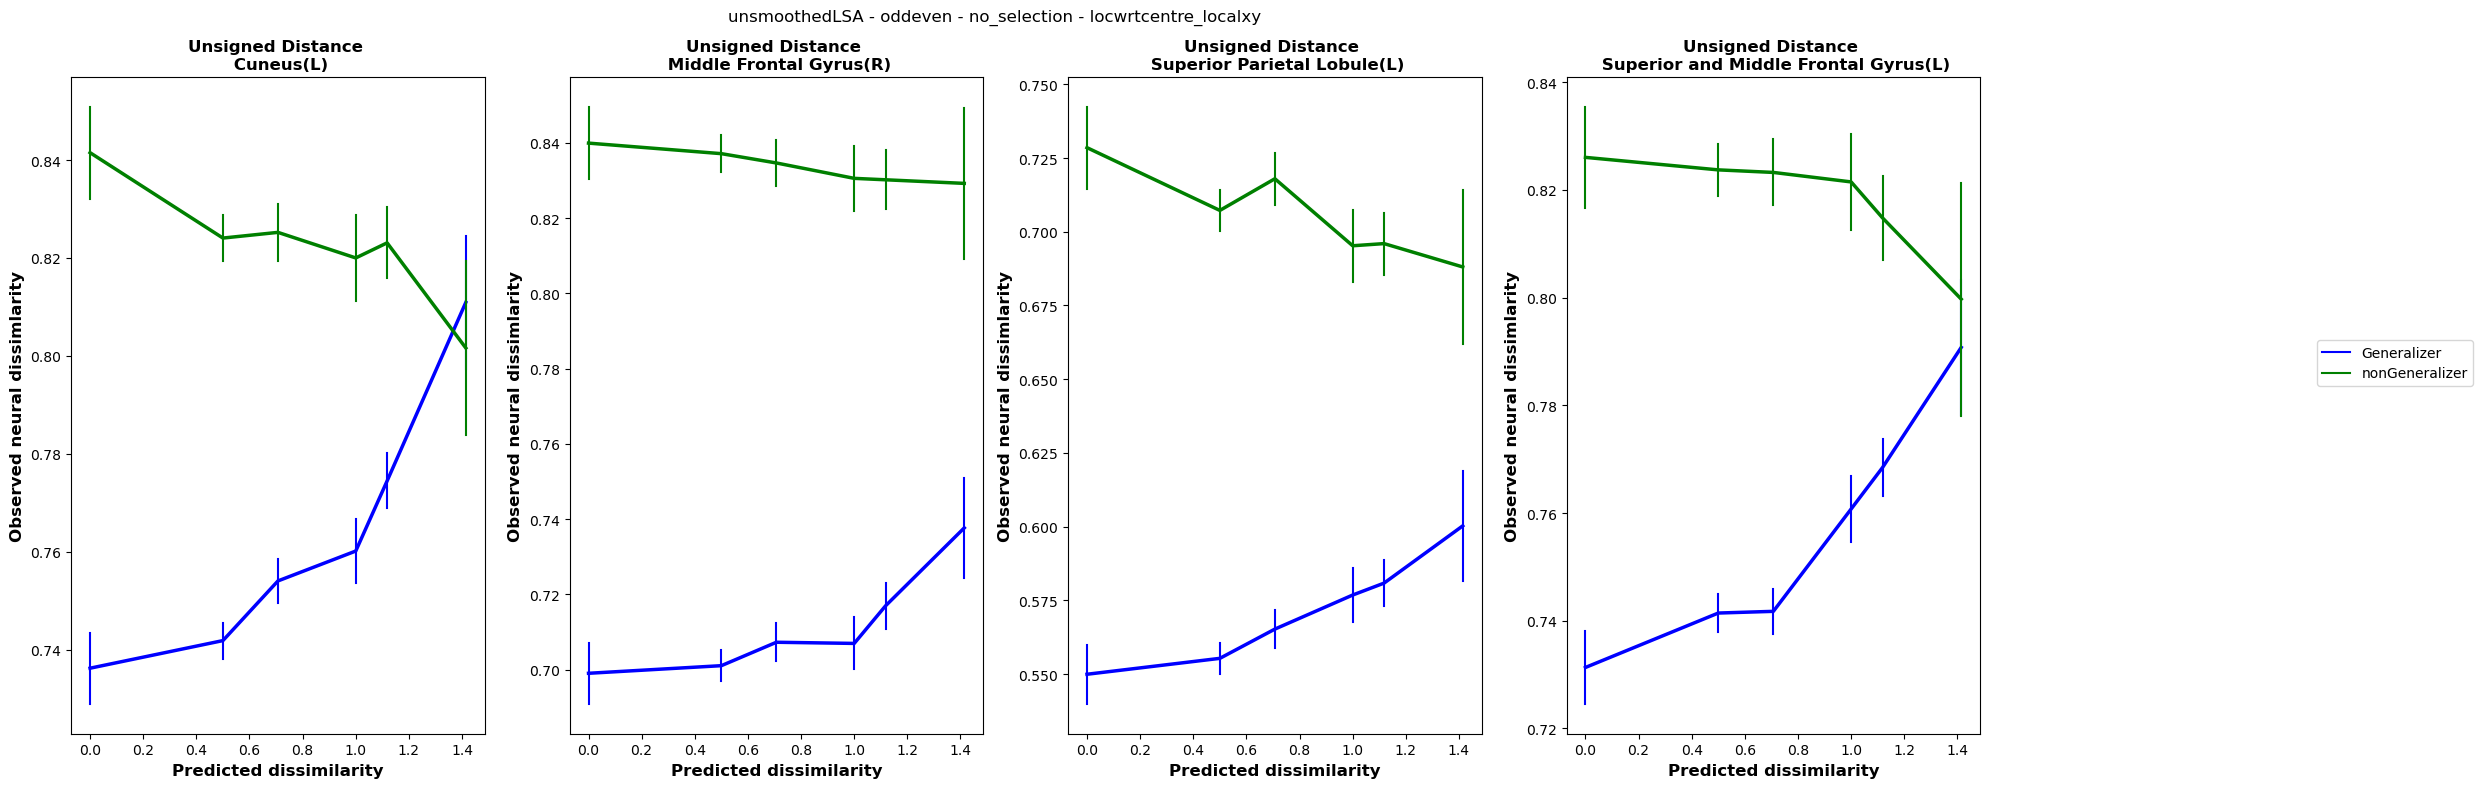

In [16]:
mn = "locwrtcentre_localxy"
m = modelrdm_cols[mn]
fig_suptitle = f'{p} - {ds_name} - {vselect} - {mn}'
print(fig_suptitle)
roi_dict = dict(zip(
    ['Unsigned Distance \n Cuneus(L)','Unsigned Distance \n Superior Parietal Lobule(L)',
     'Unsigned Distance \n Middle Frontal Gyrus(R)','Unsigned Distance \n Superior and Middle Frontal Gyrus(L)', 
     ],
    ['xydist_LeftCuneus','xydist_LeftParietalSup',
     'xydist_RightFrontalMidSup','xydist_LeftFrontalSup',
     ]
     ))
prows, pcols = np.unique(df['run_comb']).size, len(roi_dict)
fig,axes = plt.subplots(nrows=prows,ncols=pcols,figsize=(20,8))
j = 0
for _,(g_name,g_df) in list(enumerate(df.groupby(['laterality','run_comb','roi']))):
    if (g_name[2] in roi_dict.keys()):   
        subdf = g_df.groupby([m,'type','subid'])['neural'].mean().reset_index()
        sns.lineplot(data=g_df,x=m,y='neural',ax=axes.flatten()[j],
                    hue='type',palette=['blue','green'],#,'orange','red'],
                    err_style="bars",errorbar=("se", 1),
                    markers=True,alpha=1,linewidth=2.5)
        
        axes.flatten()[j].set_title(g_name[2],fontweight="bold",fontsize="large")
        axes.flatten()[j].set(adjustable="datalim")
        axes.flatten()[j].set_xlabel("Predicted dissimilarity",fontweight="bold",fontsize="large")
        axes.flatten()[j].set_ylabel("Observed neural dissimlarity",fontweight="bold",fontsize="large")
        j += 1
        
lines_labels = axes.flatten()[0].get_legend_handles_labels()
[ax.get_legend().remove() for ax in fig.axes if ax.get_legend() is not None]
lines, labels = [sum(lol, []) for lol in zip(lines_labels)]
#select unique legends
lgd_idx = [np.where(np.array(labels)==x)[0][0] for x in np.unique(labels)]
lines, labels = np.array(lines)[lgd_idx],np.array(labels)[lgd_idx]
lgd = fig.legend(lines, labels,loc = 'lower center',bbox_to_anchor=(1.2,0.5), ncol=1)

grid = plt.GridSpec(prows, pcols)
fig.set_facecolor('w')

fig.suptitle(fig_suptitle)
fig.tight_layout()
checkdir(os.path.join(ROIRSA_output_path,'pair-wise dissimilarity plot'))
fig.savefig(os.path.join(ROIRSA_output_path,'pair-wise dissimilarity plot',f'{p}_{ds_name}_{vselect}_{m}.png'),
            bbox_inches='tight')

## MDS

In [334]:
n_job=10
for p in preprocess[:1]:
    beta_dir = {
        #"localizer":[os.path.join(fmridata_dir,p,'LSA_stimuli_localizer')],
        "oddeven":[os.path.join(fmridata_dir,p,'LSA_stimuli_navigation')]*2,

        }
    beta_fname = {
        "localizer":['stimuli_1r.nii'],
        "oddeven":['stimuli_odd.nii',
                   'stimuli_even.nii'],
        
        }
    vs_dir = {
              "no_selection":[],
              #"reliability_ths0":[os.path.join(fmridata_dir,p,'reliability_noconcat')],
              #"perm_rmask":[os.path.join(fmridata_dir,p,'reliability_noconcat')],
              }
    for ds_name,ds in beta_dir.items():
        for vselect,vdir in vs_dir.items():
            mds_df_list = []
            rdm_df_list = []
            PS_df_list = []

            vsmask_dir = ds + vdir
            if vselect == "no_selection":
                vsmask_fname = ['mask.nii']*len(ds)
            elif vselect == "perm_rmask":
                vsmask_fname = ['mask.nii']*len(ds) + ['permuted_reliability_mask.nii']
            elif vselect == "reliability_ths0":
                vsmask_fname = ['mask.nii']*len(ds) + ['reliability_mask.nii']
            taskname = "navigation" if ds_name != "localizer" else ds_name

            for (roi,roi_fn), lat in itertools.product(roi_dict.items(), laterality):
                print(f"{p} - {ds_name} - {vselect} - {roi} = {lat}")
                funcmasks = [os.path.join(maskdir,f'{roi_fn}.nii')]
                RSA = RSARunner(participants=subid_list,
                                fmribeh_dir=fmribeh_dir,
                                beta_dir=ds, beta_fname=beta_fname[ds_name],
                                vsmask_dir=vsmask_dir, vsmask_fname=vsmask_fname,
                                pmask_dir=ds, pmask_fname=beta_fname[ds_name],
                                anatmasks=funcmasks,
                                nsession=n_sess[ds_name],
                                taskname=taskname)

unsmoothedLSA - oddeven - no_selection - Unsigned Distance 
 Cuneus(L) = bilateral
unsmoothedLSA - oddeven - no_selection - Unsigned Distance 
 Superior Parietal Lobule(L) = bilateral
unsmoothedLSA - oddeven - no_selection - Unsigned Distance 
 Middle Frontal Gyrus(R) = bilateral
unsmoothedLSA - oddeven - no_selection - Unsigned Distance 
 Superior and Middle Frontal Gyrus(L) = bilateral
unsmoothedLSA - oddeven - no_selection - Cartesian 
 Visual(Bilateral) = bilateral
unsmoothedLSA - oddeven - no_selection - notusedsphericalvisual = bilateral


In [336]:
subNeuralXRDM = [RSA.get_neuralRDM(subid) for subid in subid_list]


c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



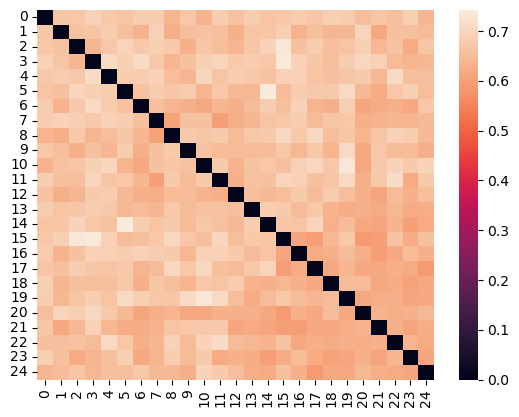

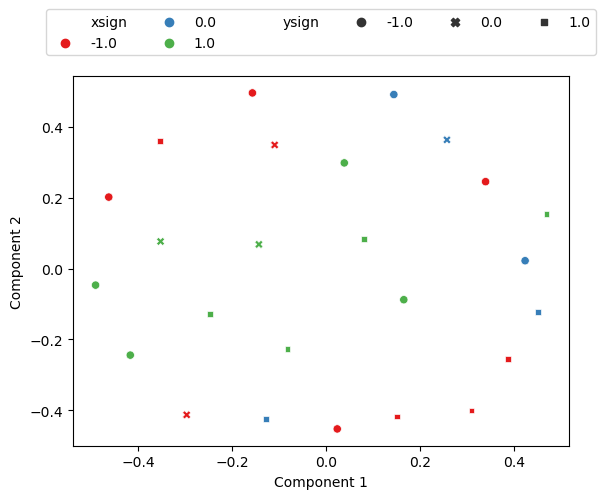

In [337]:
all_neuralRDM = [op[1][:25,25:] for op in subNeuralXRDM]
mean_neuralRDM = np.mean(all_neuralRDM,axis=0)
sym_mean = np.diag(np.zeros_like(np.diag(mean_neuralRDM)))
sym_mean[lower_tri(sym_mean)[1]] = (lower_tri(mean_neuralRDM)[0] + upper_tri(mean_neuralRDM)[0])/2
sym_mean = sym_mean + sym_mean.T - np.diag(np.diag(sym_mean))
fig,ax=plt.subplots(1,1)
sns.heatmap(sym_mean,ax=ax)

X_transformed = MDS(n_components=2,dissimilarity="precomputed").fit_transform(sym_mean)
color_shape = np.array(list(itertools.product([-1,-2,0,1,2],[-1,-2,0,1,2])))
X_transdf = pd.DataFrame(np.concatenate([X_transformed,color_shape],axis=1),columns=["Component 1","Component 2","x","y"])
X_transdf["xsign"] = np.sign(X_transdf["x"])
X_transdf["ysign"] = np.sign(X_transdf["y"])
X_transdf["xdist"] = np.abs(X_transdf["x"])
X_transdf["ydist"] = np.abs(X_transdf["y"])
fig,ax=plt.subplots(1,1)
sns.move_legend(sns.scatterplot(X_transdf,x="Component 1",y="Component 2",hue="xsign",style="ysign",ax=ax,palette="Set1"),
                loc="upper center",bbox_to_anchor=(0.5,1.2),ncol=6)

In [338]:
np.array(all_neuralRDM)[G_filter,:,:].shape

(21, 25, 25)

c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



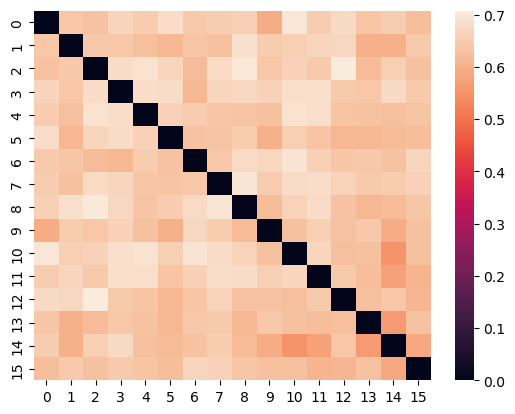

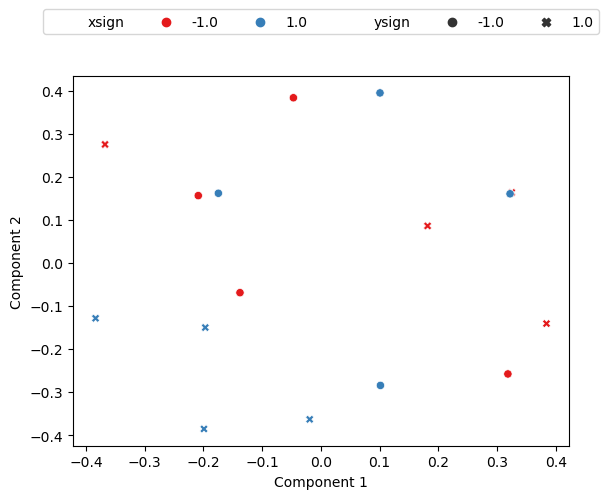

In [339]:
testidx = np.array(RSA.get_modelRDM("sub001").stimdf.stim_group==0)
all_neuralRDM = [compute_rdm(op[0][testidx,:],"correlation") for op in subNeuralXRDM]
G_filter = [not subid in nongeneralizers for subid in subid_list]
mean_neuralRDM = np.array(all_neuralRDM)[G_filter,:,:].mean(axis=0)[:16,16:]
sym_mean = np.diag(np.zeros_like(np.diag(mean_neuralRDM)))
sym_mean[lower_tri(sym_mean)[1]] = (lower_tri(mean_neuralRDM)[0] + upper_tri(mean_neuralRDM)[0])/2
sym_mean = sym_mean + sym_mean.T - np.diag(np.diag(sym_mean))
fig,ax=plt.subplots(1,1)
sns.heatmap(sym_mean,ax=ax)

X_transformed = MDS(n_components=3,dissimilarity="precomputed").fit_transform(sym_mean)
color_shape = np.array(list(itertools.product([-2,-1,1,2],[-2,-1,1,2])))
X_transdf = pd.DataFrame(np.concatenate([X_transformed,color_shape],axis=1),columns=["Component 1","Component 2","Component 3","x","y"])
X_transdf["xsign"] = np.sign(X_transdf["x"])
X_transdf["ysign"] = np.sign(X_transdf["y"])
X_transdf["xdist"] = np.abs(X_transdf["x"])
X_transdf["ydist"] = np.abs(X_transdf["y"])
fig,ax=plt.subplots(1,1)
sns.move_legend(sns.scatterplot(X_transdf,x="Component 1",y="Component 2",hue="xsign",style="ysign",ax=ax,palette="Set1"),
                loc="upper center",bbox_to_anchor=(0.5,1.2),ncol=6)

In [340]:
import plotly.express as px
fig = px.scatter_3d(X_transdf, x='Component 1', y='Component 2', z='Component 3',
              color='xsign',symbol="ysign")
fig.show()

## PCA

In [341]:
def explained_variance(X,model):
    result = np.zeros(model.n_components_)
    for ii in range(model.n_components_):
        X_trans = model.transform(X)
        X_trans_ii = np.zeros_like(X_trans)
        X_trans_ii[:, ii] = X_trans[:, ii]
        X_approx_ii = model.inverse_transform(X_trans_ii)

        result[ii] = 1 - (np.linalg.norm(X_approx_ii - X) /
                          np.linalg.norm(X - model.mean_)) ** 2
    return result

In [342]:
RSA.get_modelRDM("sub001").stimdf[testidx][:16][["stim_x","stim_y","stim_xsign","stim_ysign","stim_xdist","stim_ydist"]]

,stim_x,stim_y,stim_xsign,stim_ysign,stim_xdist,stim_ydist
0,-1.0,-1.0,-1.0,-1.0,1.0,1.0
1,-1.0,-0.5,-1.0,-1.0,1.0,0.5
3,-1.0,0.5,-1.0,1.0,1.0,0.5
4,-1.0,1.0,-1.0,1.0,1.0,1.0
5,-0.5,-1.0,-1.0,-1.0,0.5,1.0
6,-0.5,-0.5,-1.0,-1.0,0.5,0.5
8,-0.5,0.5,-1.0,1.0,0.5,0.5
9,-0.5,1.0,-1.0,1.0,0.5,1.0
15,0.5,-1.0,1.0,-1.0,0.5,1.0
16,0.5,-0.5,1.0,-1.0,0.5,0.5


In [343]:
all_neuralX = [op[0] for op in subNeuralXRDM]
testidx = np.array(RSA.get_modelRDM("sub001").stimdf.stim_group==0)
stimdf = RSA.get_modelRDM("sub001").stimdf[testidx]
teststimonly=True
cutoff = 16 if teststimonly else 25
def calculate_crossval_PCAev(X,teststimonly=True):    
    cutoff = 25
    if teststimonly:
        X = X[testidx,:]
        cutoff = 16
    X1,X2 = X[:cutoff,:],X[cutoff:,:]
    
    pca1 = PCA().fit(X1)
    pca2 = PCA().fit(X2)
    ev_self = np.vstack([pca1.explained_variance_ratio_,pca2.explained_variance_ratio_]).T
    ev_cross = np.vstack([explained_variance(X2,pca1), explained_variance(X1,pca2)]).T
    ev_df = pd.DataFrame(
        np.concatenate([ev_self,ev_cross,ev_self.cumsum(axis=0),ev_cross.cumsum(axis=0),np.atleast_2d(np.arange(cutoff)+1).T],axis=1),
        columns=["ev_within_odd","ev_within_even","ev_cross_odd","ev_cross_even",
                 "cev_within_odd","cev_within_even","cev_cross_odd","cev_cross_even","components"]
    )
    return ev_df

evs = [calculate_crossval_PCAev(X).assign(subid=subid) for X,subid in zip(all_neuralX,subid_list)]
evdf = pd.concat(evs)
evdf_long = pd.melt(evdf,id_vars=["subid","components"],
                    value_vars=["ev_within_odd","ev_within_even","ev_cross_odd","ev_cross_even",
                                "cev_within_odd","cev_within_even","cev_cross_odd","cev_cross_even"],
                                var_name="dvtype")
evdf_long[['evtype','withinbetween','datasplit']] = evdf_long.dvtype.str.split("_",expand=True)
evdf_long.head(5)


,subid,components,dvtype,value,evtype,withinbetween,datasplit
0,sub001,1.0,ev_within_odd,0.622820,ev,within,odd
1,sub001,2.0,ev_within_odd,0.066084,ev,within,odd
2,sub001,3.0,ev_within_odd,0.052195,ev,within,odd
3,sub001,4.0,ev_within_odd,0.042795,ev,within,odd
4,sub001,5.0,ev_within_odd,0.035510,ev,within,odd


True


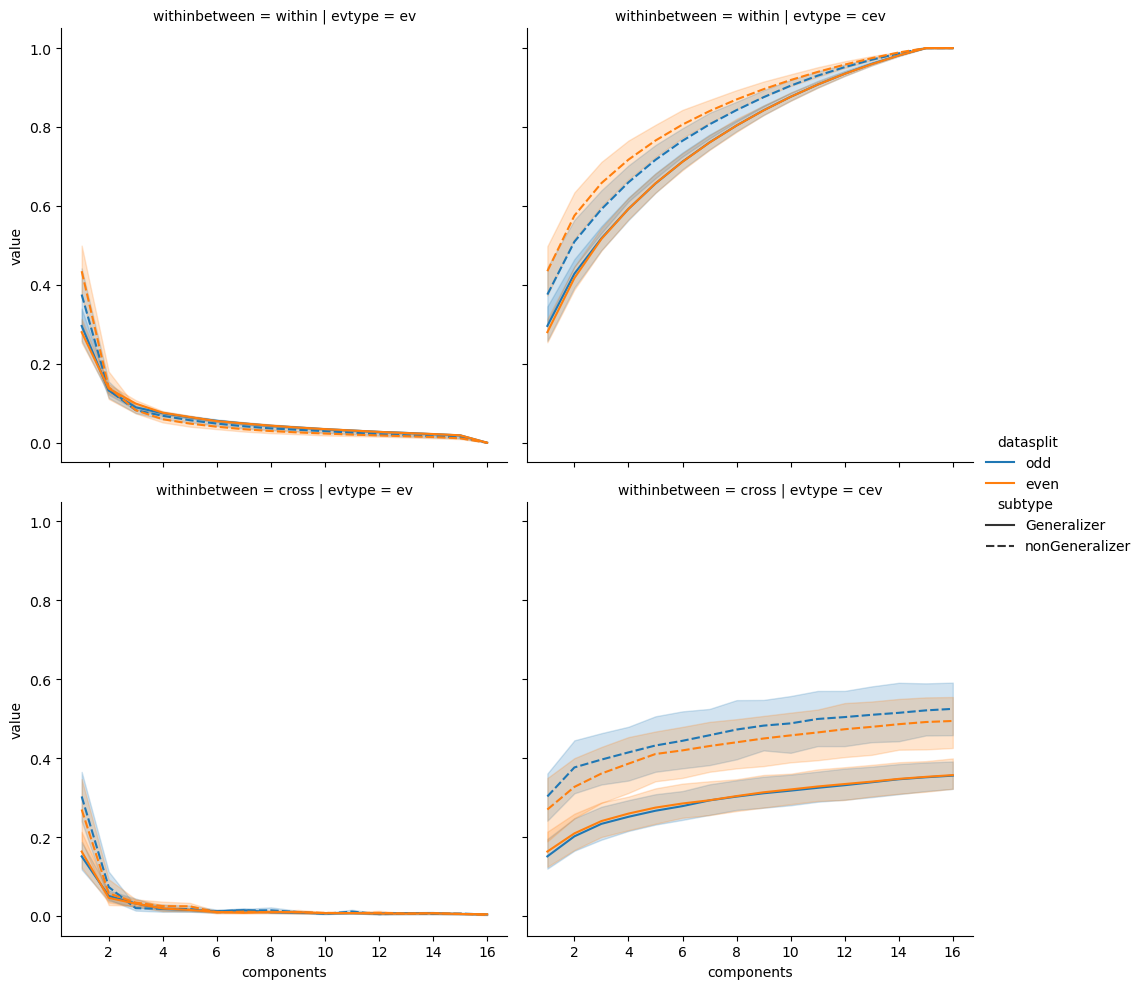

In [344]:
print(teststimonly)
sub_type_dict = {'l':{1:'nonLearner',0:'Learner'},
                 'g':{1:'nonGeneralizer',0:'Generalizer'}}
evdf_long['subtype'] = evdf_long['subid'].apply(
                lambda x: f"{sub_type_dict['g'][int(x in nongeneralizers)]}" #{sub_type_dict['l'][int(x in nonlearners)]} - 
            )
sns.relplot(
    data=evdf_long,
    x="components",y="value",
    hue="datasplit",style="subtype",
    row="withinbetween",
    col="evtype",
    kind="line"
)


Text(0.5, 1.0, 'nPC = 2')

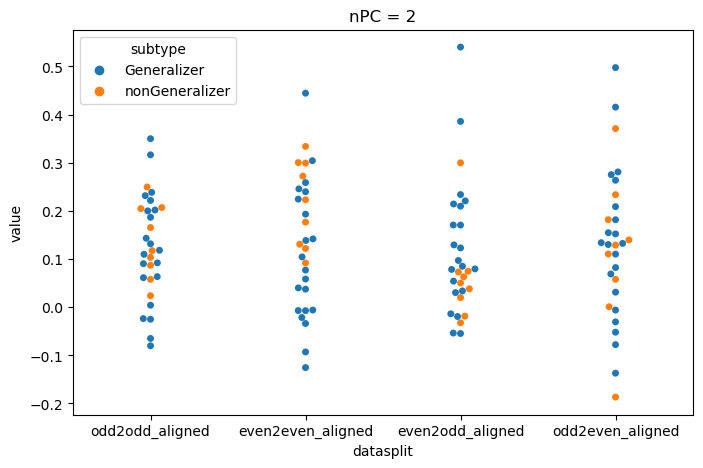

In [345]:
def align_cross_PCA(X,keepPCs=10,teststimonly=True):
    cutoff = 25
    if teststimonly:
        X = X[testidx,:]
        cutoff = 16
    X1,X2 = X[:cutoff,:],X[cutoff:,:]
    pca1 = PCA().fit(X1)
    pca2 = PCA().fit(X2)
    X2_hat = pca1.transform(X2)
    X1_hat = pca2.transform(X1)
    X1_hat_aligned,X2_hat_aligned = CCA(n_components=keepPCs).fit_transform(X1_hat[:,:keepPCs],X2_hat[:,:keepPCs])
    meanaligned = np.mean([scale_feature(X1_hat_aligned,2,True),scale_feature(X2_hat_aligned,2,True)],axis=0)
    # rdm_preserved = [
    #     scipy.stats.spearmanr(lower_tri(compute_rdm(X1,"correlation"))[0],lower_tri(compute_rdm(X1_hat_aligned[:,:keepPCs],"correlation"))[0]),
    #     scipy.stats.spearmanr(lower_tri(compute_rdm(X2,"correlation"))[0],lower_tri(compute_rdm(X2_hat_aligned[:,:keepPCs],"correlation"))[0])
    # ]
    rdm_preserved = [
        scipy.stats.spearmanr(lower_tri(compute_rdm(X1,"correlation"))[0],lower_tri(compute_rdm(meanaligned[:,:keepPCs],"correlation"))[0]),
        scipy.stats.spearmanr(lower_tri(compute_rdm(X2,"correlation"))[0],lower_tri(compute_rdm(meanaligned[:,:keepPCs],"correlation"))[0])
    ]    
    return meanaligned, X1_hat_aligned,X2_hat_aligned, rdm_preserved

def align_within_PCA(X,keepPCs=10,teststimonly=True):
    cutoff = 25
    if teststimonly:
        X = X[testidx,:]
        cutoff = 16
    X1,X2 = X[:cutoff,:],X[cutoff:,:]
    X1_hat = PCA().fit_transform(X1)
    X2_hat = PCA().fit_transform(X2)
    X1_hat_aligned,X2_hat_aligned = CCA(n_components=keepPCs).fit_transform(X1_hat[:,:keepPCs],X2_hat[:,:keepPCs])
    meanaligned = np.mean([scale_feature(X1_hat_aligned,2,True),scale_feature(X2_hat_aligned,2,True)],axis=0)
    # rdm_preserved = [
    #     scipy.stats.spearmanr(lower_tri(compute_rdm(X1,"correlation"))[0],lower_tri(compute_rdm(X1_hat_aligned[:,:keepPCs],"correlation"))[0]),
    #     scipy.stats.spearmanr(lower_tri(compute_rdm(X2,"correlation"))[0],lower_tri(compute_rdm(X2_hat_aligned[:,:keepPCs],"correlation"))[0])
    # ]    
    rdm_preserved = [
        scipy.stats.spearmanr(lower_tri(compute_rdm(X1,"correlation"))[0],lower_tri(compute_rdm(meanaligned[:,:keepPCs],"correlation"))[0]),
        scipy.stats.spearmanr(lower_tri(compute_rdm(X2,"correlation"))[0],lower_tri(compute_rdm(meanaligned[:,:keepPCs],"correlation"))[0])
    ]
    return meanaligned,X1_hat_aligned,X2_hat_aligned, rdm_preserved

nPC=2
rdm_preserved = pd.DataFrame(
   np.concatenate(
       [np.array([[r.statistic for r in align_within_PCA(x,keepPCs=nPC)[3]] for x in all_neuralX]),
        np.array([[r.statistic for r in align_cross_PCA(x,keepPCs=nPC)[3]] for x in all_neuralX])],
   axis=1),   
     columns=["odd2odd_aligned","even2even_aligned","even2odd_aligned","odd2even_aligned"]
)
rdm_preserved["subid"] = subid_list
rdm_preserved = pd.melt(rdm_preserved,id_vars="subid",value_vars=["odd2odd_aligned","even2even_aligned","even2odd_aligned","odd2even_aligned"],var_name="datasplit")
sub_type_dict = {'l':{1:'nonLearner',0:'Learner'},
                 'g':{1:'nonGeneralizer',0:'Generalizer'}}
rdm_preserved['subtype'] = rdm_preserved['subid'].apply(
                lambda x: f"{sub_type_dict['g'][int(x in nongeneralizers)]}" #{sub_type_dict['l'][int(x in nonlearners)]} - 
            )
fig,ax=plt.subplots(1,1,figsize=(8,5))
sns.swarmplot(
    data=rdm_preserved,
    x="datasplit",y="value",
    hue="subtype",
    ax=ax
)
ax.set_title(f"nPC = {nPC}")


In [346]:
rdm_preserved_dfs = []
for nPC in np.arange(13)+2:
    print(nPC)
    rdm_preserved_df = pd.DataFrame(
        np.concatenate(
            [np.array([[r.statistic for r in align_within_PCA(x,keepPCs=nPC)[3]] for x in all_neuralX]),
                np.array([[r.statistic for r in align_cross_PCA(x,keepPCs=nPC)[3]] for x in all_neuralX])],
        axis=1),   
            columns=["odd2odd_aligned","even2even_aligned","even2odd_aligned","odd2even_aligned"]
        )
    rdm_preserved_df["subid"] = subid_list
    rdm_preserved_df = pd.melt(rdm_preserved_df,id_vars="subid",
                            value_vars=["odd2odd_aligned","even2even_aligned","even2odd_aligned","odd2even_aligned"],var_name="datasplit").assign(nPC=nPC)
    rdm_preserved_dfs.append(rdm_preserved_df)
rdm_preserved = pd.concat(rdm_preserved_dfs)
sub_type_dict = {'l':{1:'nonLearner',0:'Learner'},
                    'g':{1:'nonGeneralizer',0:'Generalizer'}}
rdm_preserved['subtype'] = rdm_preserved['subid'].apply(
                lambda x: f"{sub_type_dict['g'][int(x in nongeneralizers)]}" #{sub_type_dict['l'][int(x in nonlearners)]} - 
            )
rdm_preserved.head(5)

2
3
4
5
6
7
8


c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning:

Maximum number of iterations reached



9
10
11
12
13
14


,subid,datasplit,value,nPC,subtype
0,sub001,odd2odd_aligned,0.061233,2,Generalizer
1,sub002,odd2odd_aligned,0.023678,2,nonGeneralizer
2,sub003,odd2odd_aligned,0.118122,2,Generalizer
3,sub004,odd2odd_aligned,0.086957,2,nonGeneralizer
4,sub005,odd2odd_aligned,0.143093,2,Generalizer


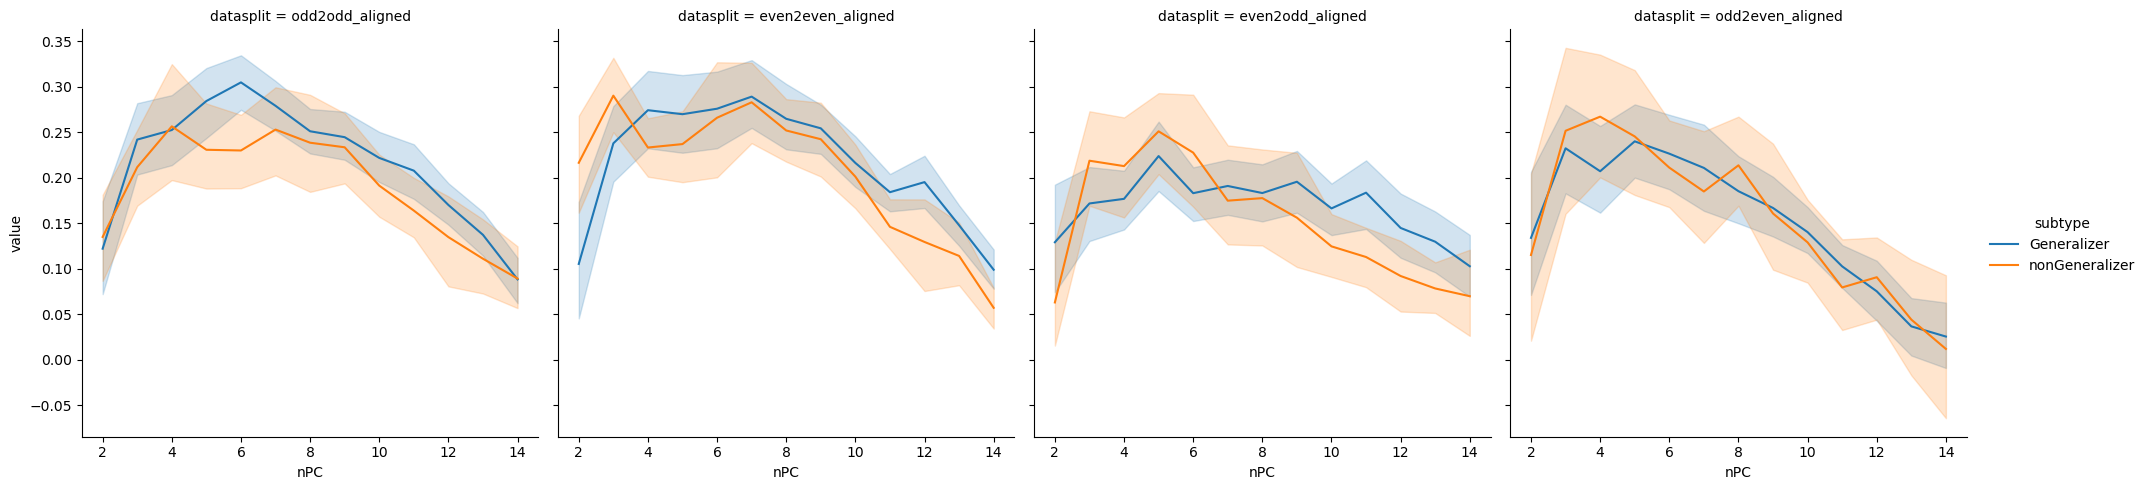

In [347]:
sns.relplot(
    data=rdm_preserved,
    x="nPC",y="value",
    col="datasplit",hue="subtype",
    kind="line"
)

because it seeems that nPC=6 keeps the best correlation with original data, so we proceed with nPC=6

In [348]:
nPC=6
all_neuralX_withinPCA =[align_within_PCA(x,keepPCs=nPC) for x in all_neuralX]
all_neuralX_crossPCA = [align_cross_PCA(x,keepPCs=nPC) for x in all_neuralX]

In [349]:
def get_corr_mat(A,B=None,self_corr=False,keep_lower=True,metric="pearson"):
    corrfunc = {
        "pearson":   lambda x,y: (scipy.stats.pearsonr(x,y).statistic,scipy.stats.pearsonr(x,y).pvalue),
        "spearman":   lambda x,y: (scipy.stats.spearmanr(x,y).correlation,scipy.stats.spearmanr(x,y).pvalue),
        "linregress": lambda x,y: (scipy.stats.linregress(scale_feature(x),scale_feature(y)).slope,scipy.stats.linregress(scale_feature(x),scale_feature(y)).pvalue)
        #(scipy.stats.linregress(x,y).slope,scipy.stats.linregress(x,y).pvalue)
        #(scipy.stats.linregress(scale_feature(x),scale_feature(y)).slope,scipy.stats.linregress(scale_feature(x),scale_feature(y)).pvalue)
    }
    if B is None:
        self_corr = True
        B = deepcopy(A)
    
    m,n = A.shape[1],B.shape[1]
    corr_mat,pval_mat = np.full((m,n),fill_value=np.nan),np.full((m,n),fill_value=np.nan)
    for j,k in itertools.product(range(m),range(n)):
        corr_mat[j,k], pval_mat[j,k] = corrfunc[metric](A[:,j],B[:,k])
        
    if self_corr and keep_lower:
        res = {
            "correlation":corr_mat,
            "pvalue":pval_mat
        }
        corr_mat, pval_mat = np.full((m,n),fill_value=np.nan),np.full((m,n),fill_value=np.nan)
        corr_mat[lower_tri(res["correlation"])[1]] = lower_tri(res["correlation"])[0]
        pval_mat[lower_tri(res["pvalue"])[1]] = lower_tri(res["pvalue"])[0]
        return corr_mat, pval_mat
    else:
        return corr_mat, pval_mat

In [350]:
def sigstr(pval):
    if pval>=0.05:
        return ""    
    else:
        if pval>0.01:
            return "*"
        else:
            if pval>0.001:
                return "**"
            else:
                return "***"
f"{'{0:.2f}'.format(3.14)}{sigstr(0.04)}"

'3.14*'

In [351]:
RSA.get_modelRDM("sub001").stimdf[testidx][:16][["stim_x","stim_y","stim_xsign","stim_ysign","stim_xdist","stim_ydist"]]

,stim_x,stim_y,stim_xsign,stim_ysign,stim_xdist,stim_ydist
0,-1.0,-1.0,-1.0,-1.0,1.0,1.0
1,-1.0,-0.5,-1.0,-1.0,1.0,0.5
3,-1.0,0.5,-1.0,1.0,1.0,0.5
4,-1.0,1.0,-1.0,1.0,1.0,1.0
5,-0.5,-1.0,-1.0,-1.0,0.5,1.0
6,-0.5,-0.5,-1.0,-1.0,0.5,0.5
8,-0.5,0.5,-1.0,1.0,0.5,0.5
9,-0.5,1.0,-1.0,1.0,0.5,1.0
15,0.5,-1.0,1.0,-1.0,0.5,1.0
16,0.5,-0.5,1.0,-1.0,0.5,0.5


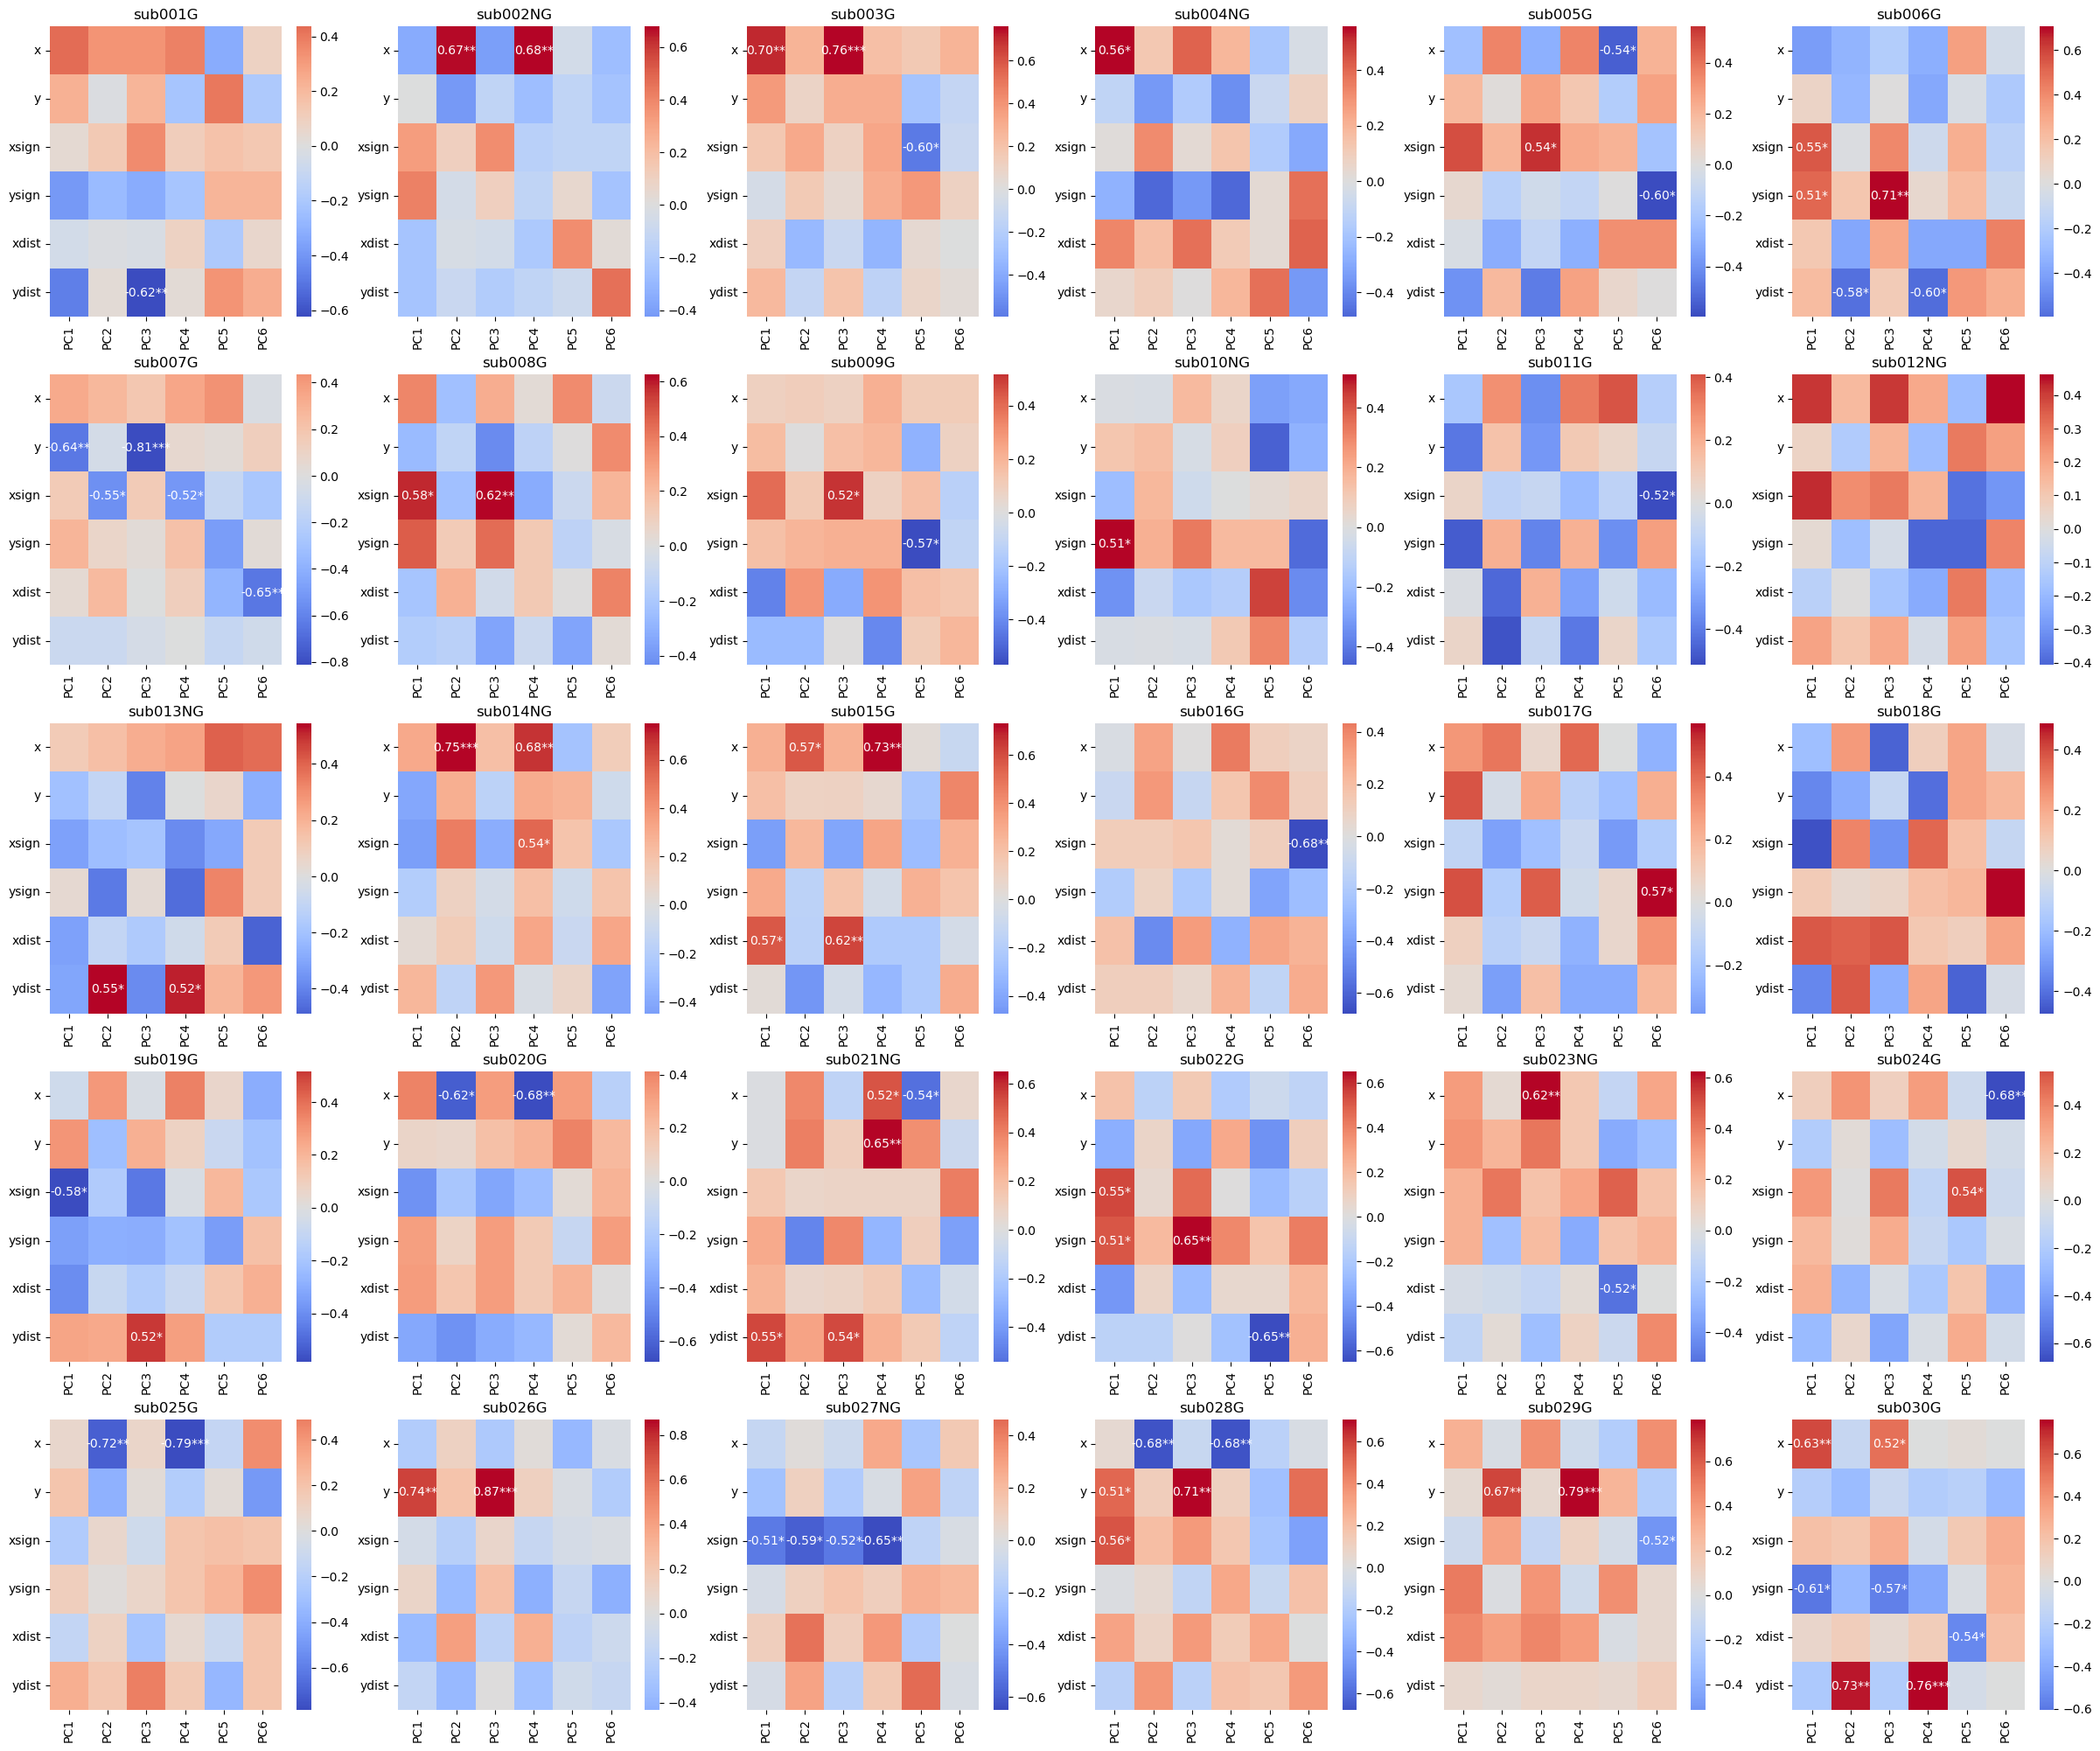

In [352]:
stim_fs = np.array(list(itertools.product([-2,-1,1,2],[-2,-1,1,2])))
stim_fs = np.concatenate([
    stim_fs,
    np.sign(stim_fs),
    np.abs(stim_fs)
],axis=1)
Acol = [f"PC{k}" for k in np.arange(nPC)+1]
Bcol = ["x","y","xsign","ysign","xdist","ydist"] 
cmats=[get_corr_mat(A=Xtransform[0],B=stim_fs,self_corr=False,keep_lower=True,metric="spearman") for Xtransform in all_neuralX_withinPCA]
fig,axes = plt.subplots(5,6,figsize=(30,25))
for jsub,subid in enumerate(subid_list[:]):
    annot_mat = np.reshape([f"{'{0:.2f}'.format(x)}{sigstr(psig)}" if psig<0.05 else "" for x,psig in zip(cmats[jsub][0].flatten(),cmats[jsub][1].flatten())],
                           cmats[jsub][0].shape)
    sns.heatmap(
                cmats[jsub][0],
                annot=annot_mat,
                fmt='',
                cmap="coolwarm",center=0,
                ax=axes.flatten()[jsub]
                        )
    axes.flatten()[jsub].set_xticklabels(Acol,rotation=90)
    axes.flatten()[jsub].set_yticklabels(Bcol,rotation=0)
    axes.flatten()[jsub].set_title(subid+["G","NG"][int(subid in nongeneralizers)])

In [303]:
"sub025" in nongeneralizers 

False

In [310]:
mean_X_trans=[op[0] for op in all_neuralX_withinPCA]
for jsub,subid in enumerate(subid_list[27:28]):
    print(subid)
    transdf = pd.DataFrame(np.concatenate([stim_fs,mean_X_trans[jsub]],axis=1),
                columns=Bcol+Acol).assign(subid=subid)
#     #X_transdfs.append(transdf)

#X_transdf = pd.concat(X_transdfs)
X_transdf = transdf
sub_type_dict = {'l':{1:'nonLearner',0:'Learner'},
                    'g':{1:'nonGeneralizer',0:'Generalizer'}}
X_transdf['subtype'] = X_transdf['subid'].apply(
                lambda x: f"{sub_type_dict['g'][int(x in nongeneralizers)]}" #{sub_type_dict['l'][int(x in nonlearners)]} - 
            )
X_transdf["xsign"] = np.sign(X_transdf["x"])
X_transdf["ysign"] = np.sign(X_transdf["y"])
X_transdf["xdist"] = np.abs(X_transdf["x"])
X_transdf["ydist"] = np.abs(X_transdf["y"])

# fig,axes = plt.subplots(1,3,figsize=(16,4))
# sns.move_legend(sns.scatterplot(X_transdf,x="PC1",y="PC4",hue="xsign",style="ysign",palette="Set1",ax=axes[0]),
#                 loc="upper center",bbox_to_anchor=(1,1.2),ncol=12)
# sns.move_legend(sns.scatterplot(X_transdf,x="x",y="PC2",style="y",ax=axes[1]),
#                 loc="upper center",bbox_to_anchor=(0.5,1.2),ncol=5)
# axes[1].legend().remove()
# sns.move_legend(sns.scatterplot(X_transdf,x="y",y="PC6",hue="x",palette="Set1",ax=axes[2]),
#                 loc="upper center",bbox_to_anchor=(0.5,1.2),ncol=5)
# axes[2].legend().remove()
#fig.tight_layout()

import plotly.express as px
fig = px.scatter_3d(X_transdf, x='PC1', y='PC2', z='PC3',
              color='xsign',symbol="ysign")
fig.show()

sub025


9

In [ ]:
NG_CCA,NG_subid = []
G_CCA = []
G_ref = mean_X_trans[0]
NGref = mean_X_trans[subid_list.index(nongeneralizers[0])]

for subid,meanX in zip(subid_list,mean_X_trans):
    if subid in nongeneralizers:
        if subid!=nongeneralizers[0]:
            NG_CCA.append(CCA(n_components=nPC).fit_transform(NGref,meanX))
            NG_subid.append(subid)
            